In [1]:
from io_su2.file_read_util import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from vandv_tools.util import *
from vandv_tools.pv import *
from vandv_tools.discretization_error import *
from prettytable import PrettyTable

textFontSize = 16
tickFontSize = 14
matplotlib.rc('font', size=tickFontSize)

In [4]:
# Read and write SU2 data

run_data = {}

# folder set up
mesh_folders = ['L5','L4','L3','L2','L1']
models = ['SA']
grads = {'gg' : 'GREEN_GAUSS'}
recon_grads = ['2nd_order']

coeffs = ['CD','CF']
locs = ["x=0.97008", "x=1.90334"]

mesh_files = get_mesh_names(os.getcwd())
mesh_data = get_mesh_family_data(mesh_files)

for model in models:
    run_data[model] = {}
    for grad in grads:
        run_data[model][grad] = {}
        for recon in recon_grads:
            run_data[model][grad][recon] = {}
            run_data[model][grad][recon]["CD"] = [0.0] * len(mesh_folders)
            run_data[model][grad][recon]["CF"] = [0.0] * len(mesh_folders)
            for i,level in enumerate(mesh_folders):
                hist_fn = '{}/{}/{}/{}/history.dat'.format(model,grad,recon,level)
                vol_fn = '{}/{}/{}/{}/vol_solution.vtu'.format(model,grad,recon,level)
                final_vals = get_final_vals(hist_fn)
                pv = PVWrapper(filename = vol_fn) ##
                extracted_data = pv.extract_variables_at_loc(loc=(0.97008,0.0,0.0),eps=1e-4) ##
                cf = extracted_data['Skin_Friction_Coefficient']
                if 'L1' in level:
                    extracted_line = pv.extract_variables_along_axis(loc=(0.97008,0.0)) ##
                    run_data[model][grad][recon]["x=0.97008"] = extracted_line
                    extracted_line = pv.extract_variables_along_axis(loc=(1.90334,0.0)) ##
                    run_data[model][grad][recon]["x=1.90334"] = extracted_line
                run_data[model][grad][recon]["CD"][i]= final_vals['CD']
                run_data[model][grad][recon]["CF"][i]= cf[0]
            
            # Write mesh convergence data
            writing_fn = 'plot_data/mesh_convergence/su2_{}_{}_{}.csv'.format(model.lower(),grad,recon)
            writing_data = np.transpose(np.array([mesh_data['h'],run_data[model][grad][recon]["CD"],run_data[model][grad][recon]["CF"]]))
            np.savetxt(writing_fn,writing_data,delimiter=',',header='h,CD,CF',comments='')
            
            # Write location data
            for loc in locs:
                writing_fn = 'plot_data/extracted_lines/su2_{}_{}_{}_{}.csv'.format(model.lower(),grad,recon,loc)
                writing_data = np.reshape(run_data[model][grad][recon][loc]['X'],(-1,1))
                header = 'X'
                npoint = np.shape(writing_data)[0]
                for var,val in run_data[model][grad][recon][loc].items():
                    if var == 'X':
                        continue
                    val = np.reshape(val,(npoint,-1))
                    header += ','+var
                    if np.shape(val)[1]>1:
                        header += '_X,'+var+'_Y,'+var+'_Z'
                    writing_data = np.append(writing_data,val,axis=1)
                np.savetxt(writing_fn,writing_data,delimiter=',',header=header,comments='')

In [6]:
# Read and write TMR Data
tmr_data = {}
tmr_labels = {'CD':'C_D',
              'CF':'C_f'}
coeffs = ['CD','CF']
tmr_mesh_data = []
for model in models:
    tmr_data[model] =  {}
    for coeff in coeffs:
        tmr_data[model][coeff] = {}
        tmr_fn = 'tmr_data/flatplate_{}_{}_convergence.dat'.format(model.lower(),coeff.lower())
        curr_data = tecplot_reader(tmr_fn)
        for solver,solver_data in curr_data.items():
            tmr_mesh_data = solver_data['h=sqrt(1/N)']
            tmr_data[model][coeff][solver] = solver_data[tmr_labels[coeff]]
    
    for solver in tmr_data[model][coeff].keys():
        writing_fn = 'plot_data/mesh_convergence/{}_{}.csv'.format(solver.lower(),model.lower())
        writing_data = np.transpose((tmr_mesh_data,tmr_data[model]['CD'][solver],tmr_data[model]['CF'][solver]))
        np.savetxt(writing_fn,writing_data,delimiter=',',header='h,CD,CF',comments='')

        
coeffs = ['mut_0.97','u','u+y+','omega_k']
tmr_line_data = {}
for model in models:
    tmr_line_data[model] = {}
    for coeff in coeffs:
        if model is 'SA' and 'omega' in coeff:
            continue
        tmr_fn = 'tmr_data/flatplate_{}_{}.dat'.format(model.lower(),coeff.lower())
        tmr_line_data[model][coeff] = tecplot_reader(tmr_fn)
        for key,val in tmr_line_data[model][coeff].items():
            writing_fn = 'plot_data/extracted_lines/tmr_data/'
            if coeff == 'mut_0.97':
                writing_fn += '{}_{}_{}.csv'.format(key.lower(),model.lower(),coeff)
                writing_data = np.transpose((val['y'],
                                             val['mut']))
                header = 'y,mut'
            elif coeff == 'omega_k':
                writing_fn += '{}_{}_{}.csv'.format(key.lower(),model.lower(),coeff)
                writing_data = np.transpose((val['y'],
                                             val['omega_nondim'],
                                             val['k_nondim']))
                header = 'y,omega,k'
            elif coeff == 'u':
                loc_name = key.split(' ')[0] + key.split(' ')[-1]
                writing_fn += 'cfl3d_{}_{}_{}.csv'.format(model.lower(),coeff,loc_name)
                writing_data = np.transpose((val['y'],
                                             val['u']))
                header = 'y,u'
            elif coeff == 'u+y+':
                loc_name = key.split(' ')[0] + key.split(' ')[-1]
                writing_fn += 'cfl3d_{}_{}_{}.csv'.format(model.lower(),coeff,loc_name)
                writing_data = np.transpose((val['log(y+)'],
                                             val['u+']))
                header = 'log(y+),u+'

            np.savetxt(writing_fn,writing_data,delimiter=',',header=header,comments='')

385


In [14]:
# Read plotting data

run_data = {}
mesh_folders = ['L5','L4','L3','L2','L1']
models = ['SA']
grads = {'gg' : 'GREEN_GAUSS'}
recon_grads = ['2nd_order']

coeffs = ['CD','CF']
locs = ["x=0.97008", "x=1.90334"]

for model in models:
    run_data[model] = {}
    for grad in grads:
        run_data[model][grad] = {}
        for recon in recon_grads:
            run_data[model][grad][recon] = {}
            
            # Read mesh convergence data
            fn = 'plot_data/mesh_convergence/su2_{}_{}_{}.csv'.format(model.lower(),grad,recon)
            with open(fn) as f:
                header = f.readline()
            header = [h.strip() for h in header.split(',')]
            dtype=[]
            for var in header:
                dtype.append((var,np.float64))
            run_data[model][grad][recon]['Mesh Convergence'] = np.loadtxt(fn, dtype= dtype, comments='#', skiprows=1,delimiter=',')

            # Read extracted line data
            for loc in locs:
                fn = 'plot_data/extracted_lines/su2_{}_{}_{}_{}.csv'.format(model.lower(),grad,recon,loc)
                with open(fn) as f:
                    header = f.readline()
                header = [h.strip() for h in header.split(',')]
                dtype=[]
                for var in header:
                    dtype.append((var,np.float64))
                run_data[model][grad][recon][loc] = np.loadtxt(fn, dtype= dtype, comments='#', skiprows=1,delimiter=',')


In [15]:
tmr_data = {}
models = ['SA']
locs = ["x=0.97008", "x=1.90334"]
tmr_solvers = ['CFL3D','FUN3D']

# Read mesh convergence data
for model in models:
    tmr_data[model] = {}
    for solver in tmr_solvers:
        tmr_fn = 'plot_data/mesh_convergence/{}_{}.csv'.format(solver.lower(),model.lower())
        with open(tmr_fn) as f:
            header = f.readline()
        header = [h.strip() for h in header.split(',')]
        dtype=[]
        for var in header:
            dtype.append((var,np.float64))
        tmr_data[model][solver] = np.loadtxt(tmr_fn,dtype=dtype, comments = '#',skiprows=1,delimiter=',')

coeffs = ['mut_0.97','u','u+y+','omega_k']
tmr_line_data = {}
# Read extracted line data
for model in models:
    tmr_line_data[model] = {}
    for coeff in coeffs:
        tmr_line_data[model][coeff] = {}
        tmr_fn = 'plot_data/extracted_lines/tmr_data/'
        if model is 'SA' and 'omega' in coeff:
            continue
        if coeff == 'mut_0.97' or coeff == 'omega_k':
            for solver in tmr_solvers:
                tmr_fn = 'plot_data/extracted_lines/tmr_data/'
                tmr_fn += '{}_{}_{}.csv'.format(solver.lower(),model.lower(),coeff)
                with open(tmr_fn) as f:
                    header = f.readline()
                header = [h.strip() for h in header.split(',')]
                dtype=[]
                for var in header:
                    dtype.append((var,np.float64))
                tmr_line_data[model][coeff][solver] = np.loadtxt(tmr_fn,dtype=dtype, comments = '#',skiprows=1,delimiter=',')
        if coeff == 'u' or coeff == 'u+y+':
            for loc in locs:
                tmr_fn = 'plot_data/extracted_lines/tmr_data/'
                tmr_fn += 'cfl3d_{}_{}_{}.csv'.format(model.lower(),coeff,loc)
                with open(tmr_fn) as f:
                    header = f.readline()
                header = [h.strip() for h in header.split(',')]
                dtype=[]
                for var in header:
                    dtype.append((var,np.float64))
                tmr_line_data[model][coeff][loc] = np.loadtxt(tmr_fn,dtype=dtype, comments = '#',skiprows=1,delimiter=',')


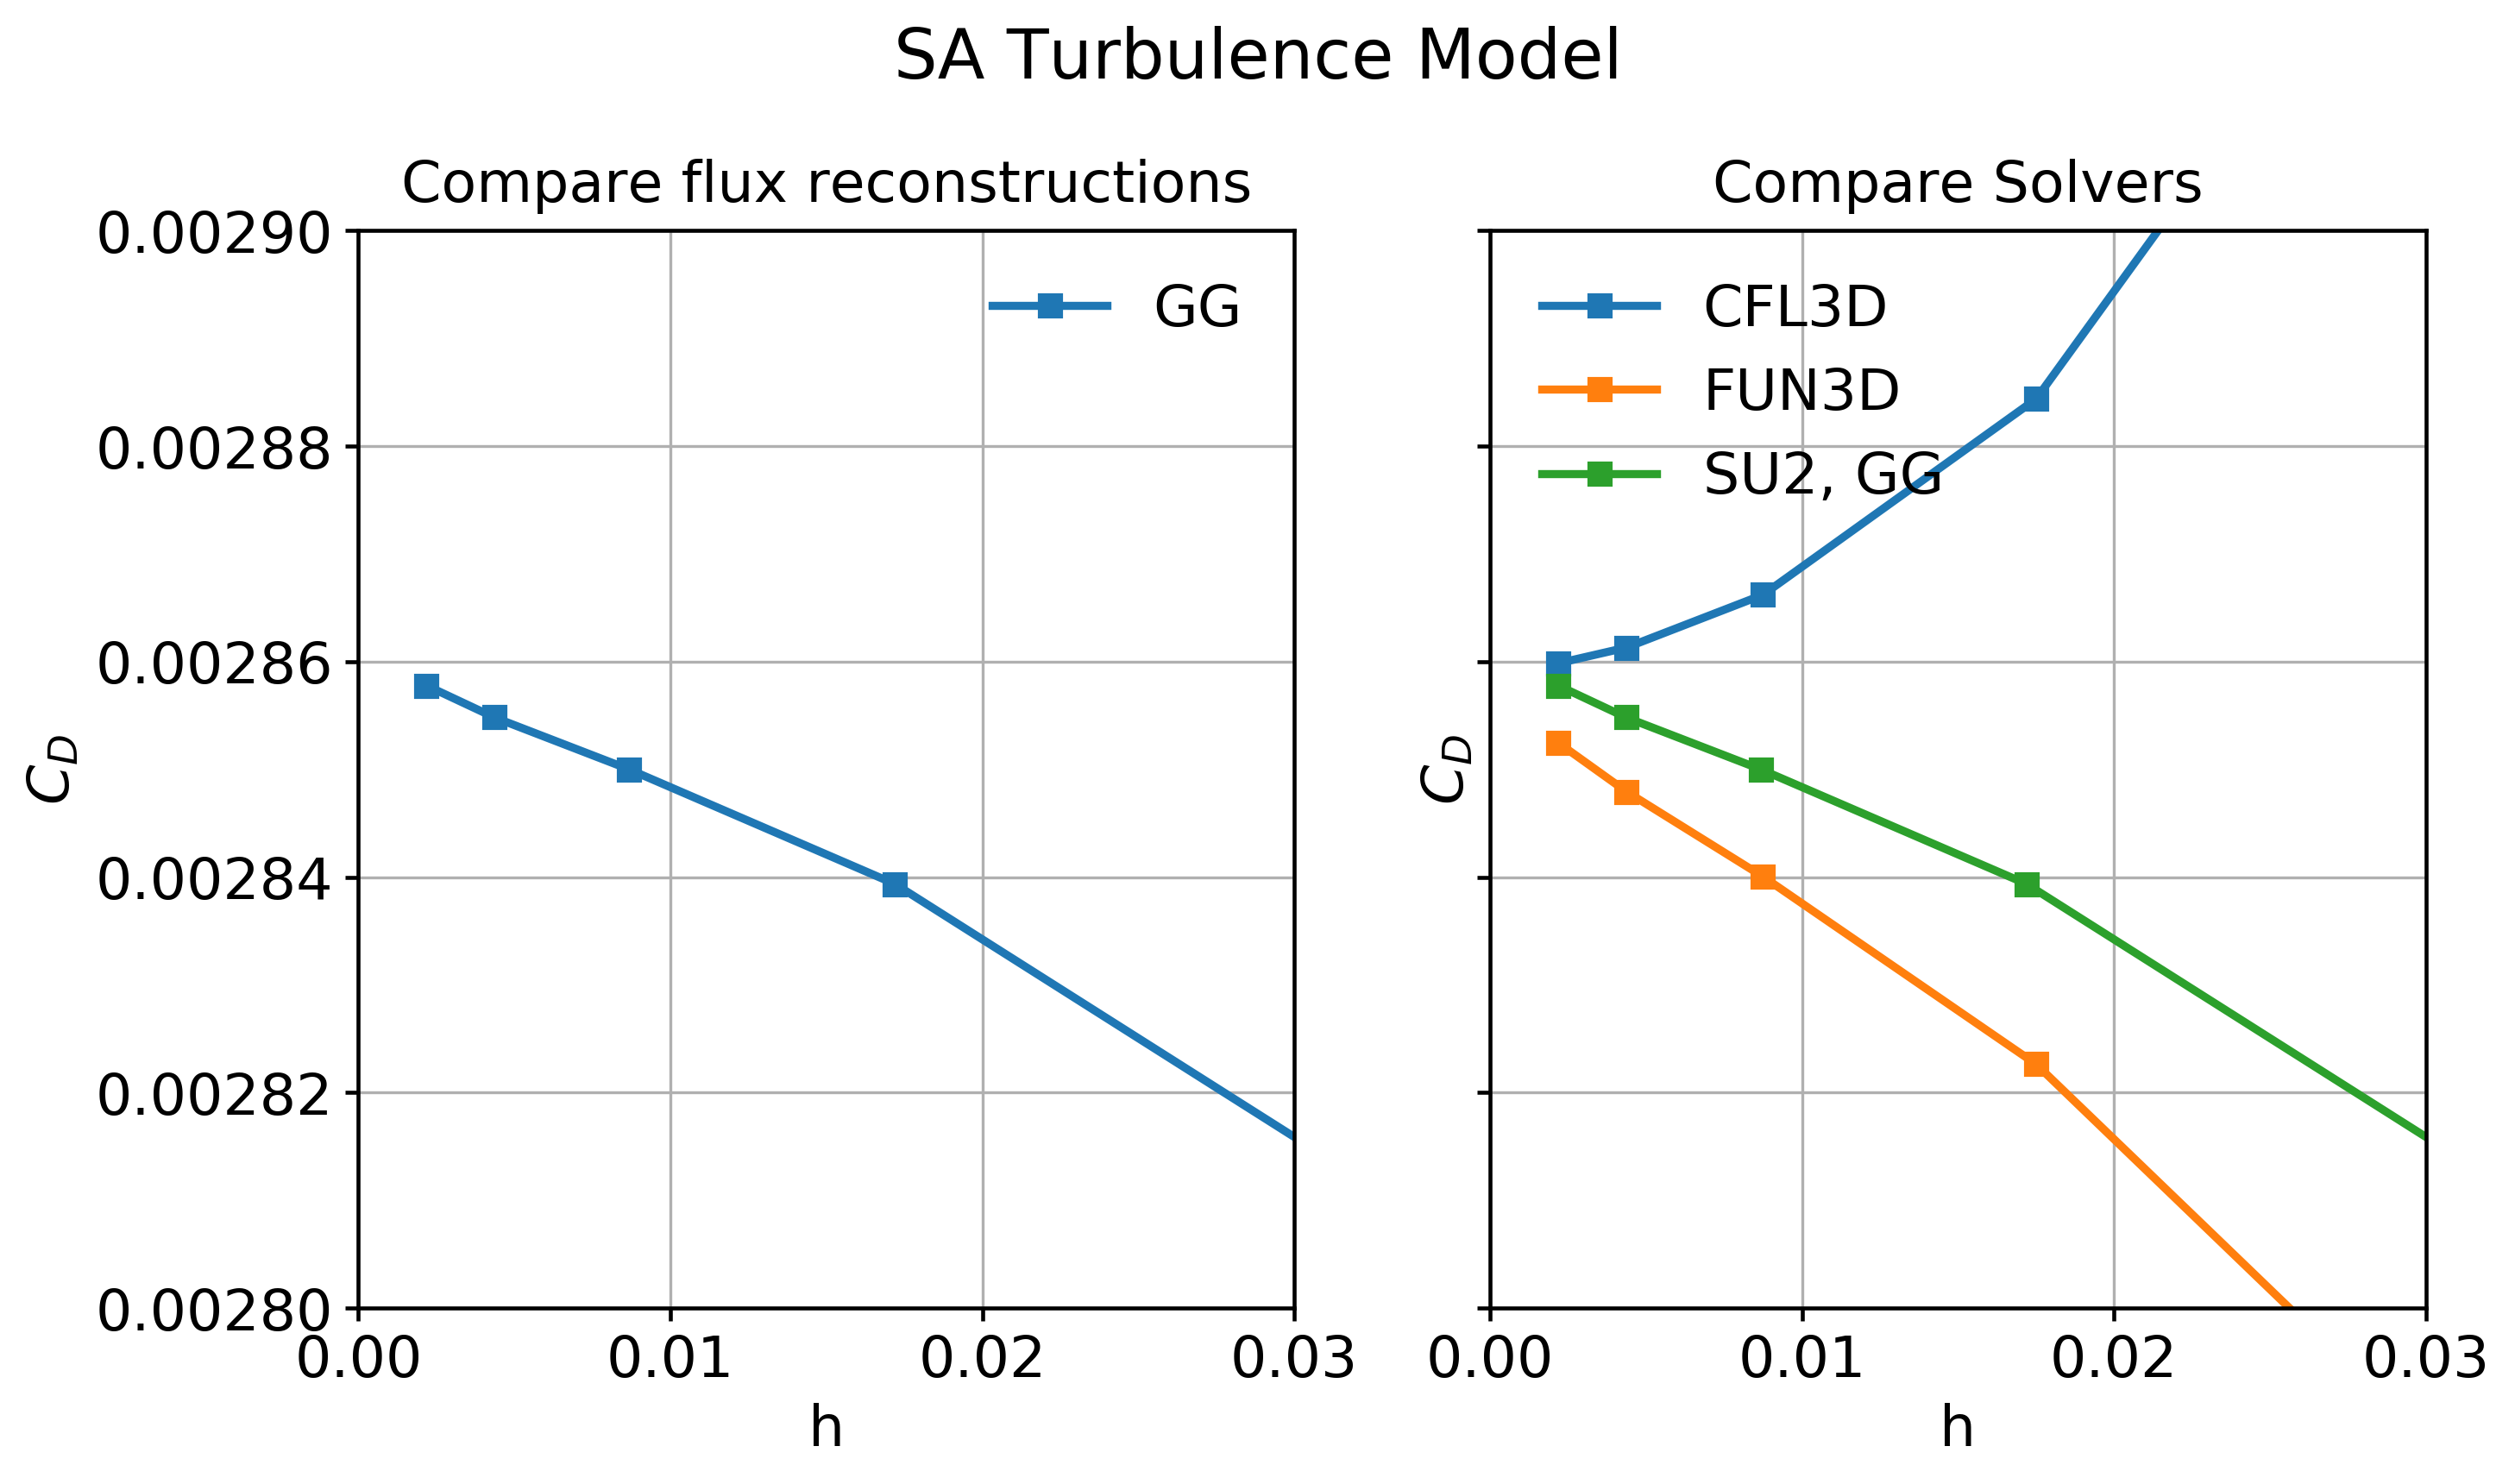

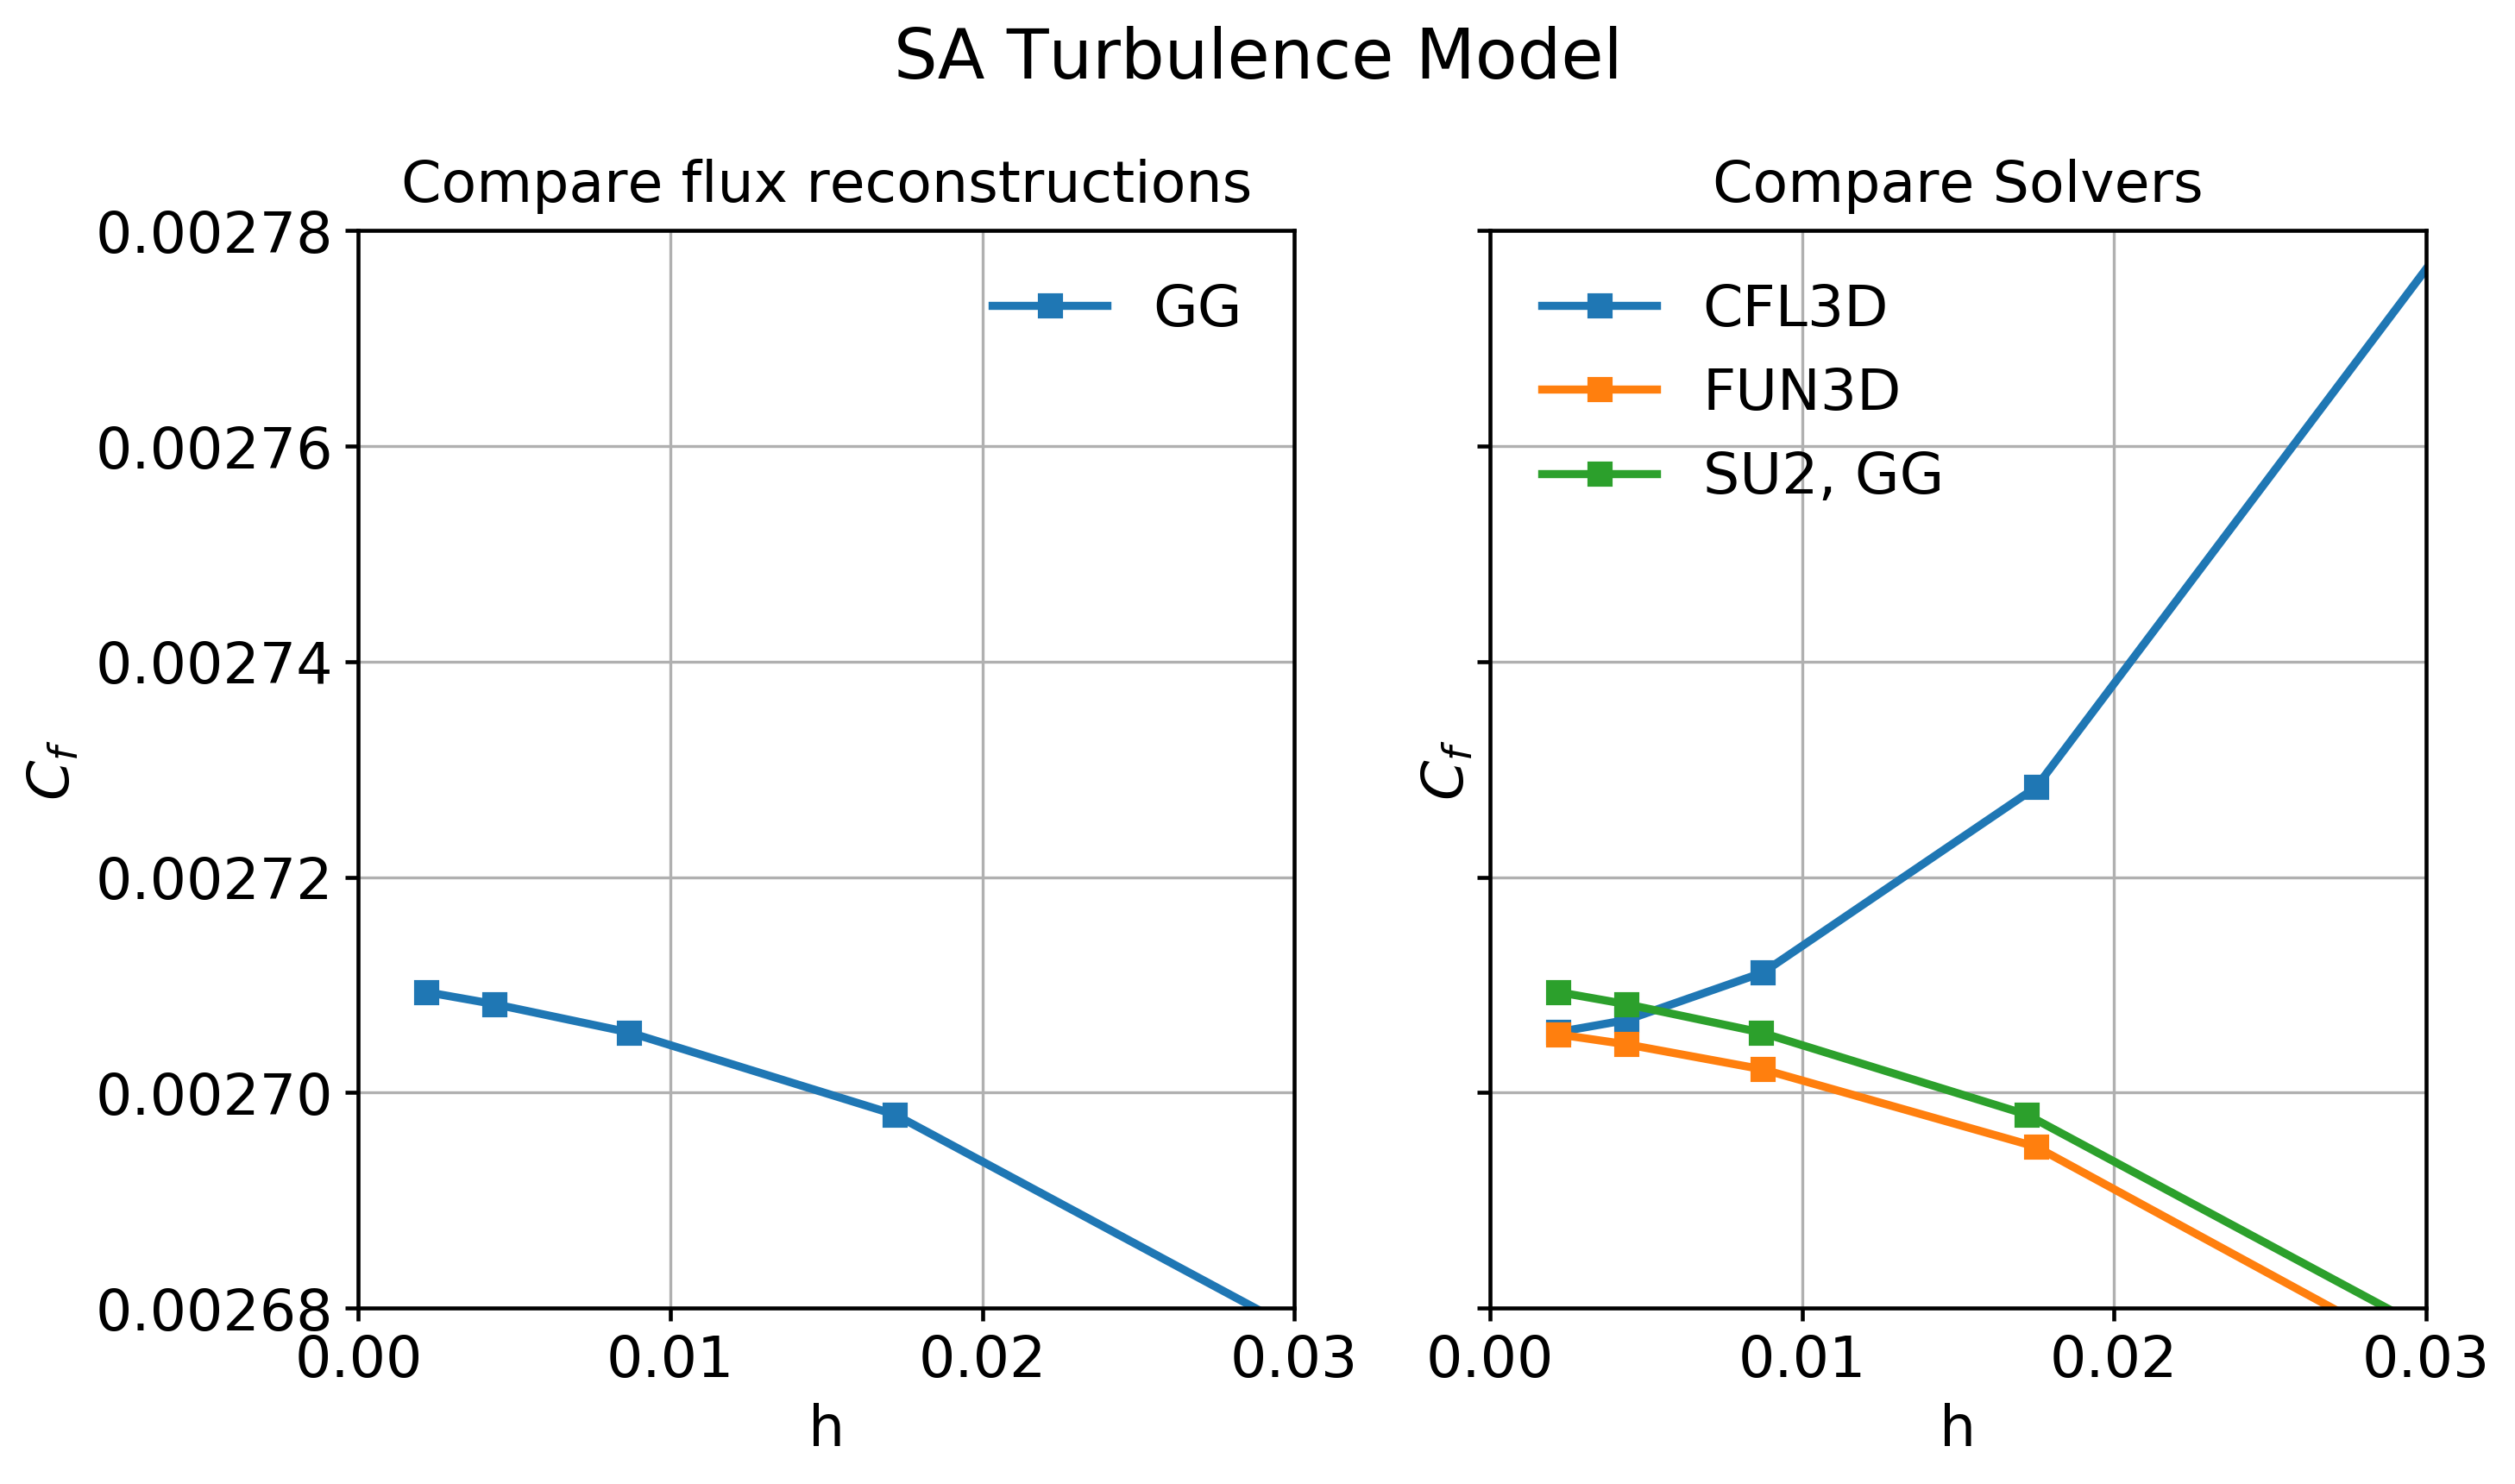

In [16]:
# Mesh Convergence plots 
# Compare 2nd order reconstructions and least squares reconstructions
# Compare SU2 with CFL3D and FUN3D

ts = 16
plot_title = 'Turbulent Flat Plate, '+r'$M = 0.2, Re_L = 5\times 10^6 (L=1)$'
plot_title = ''
recon_grads = ['2nd_order']
coeffs = ['CD', 'CF']
xlims = (0.0,0.03)
ylims = {'CD':{'SA' : (0.0028,0.0029), 'SST' : (0.0025,0.0029)},
         'CF':{'SA' : (0.00268,0.00278), 'SST' : (0.0025,0.0028)}}
ylabels = {'CD': r'$C_D$', 'CF':r'$C_f$'}

plt.style.use('presentation')

# tmr_data = {}

# for model in models:
#     tmr_data[model] = {}
#     for solver in tmr_solvers:
#         tmr_fn = 'plot_data/mesh_convergence/{}_{}.csv'.format(solver.lower(),model.lower())
#         with open(tmr_fn) as f:
#             header = f.readline()
#         header = [h.strip() for h in header.split(',')]
#         dtype=[]
#         for var in header:
#             dtype.append((var,np.float64))
#         tmr_data[model][solver] = np.loadtxt(tmr_fn,dtype=dtype, comments = '#',skiprows=1,delimiter=',')


for coeff in coeffs:
    for model in models:
        fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,5.5))
        axs[0].set_title('Compare flux reconstructions',fontsize=ts)
        axs[1].set_title('Compare Solvers',fontsize=ts)
        for solver,solver_data in tmr_data[model].items():
            axs[1].plot(solver_data['h'],solver_data[coeff],marker='s',label=solver)
        for grad in grads:
            for recon in recon_grads:
                curr_case = run_data[model][grad][recon]['Mesh Convergence']
                plot_label = grad.upper()
                if 'ls' in recon:
                    plot_label += ', ' + 'LS recon.'
                axs[0].plot(curr_case['h'],curr_case[coeff],marker='s',label=plot_label)
                if '2nd_order' in recon:
                    axs[1].plot(curr_case['h'],curr_case[coeff],marker='s',label='SU2, ' + plot_label)

                fig.suptitle(plot_title + model+' Turbulence Model',y=1.05)
                for ax in axs:
                    ax.set_xlabel(r'h')
                    ax.set_ylabel(ylabels[coeff])
                    ax.set_xlim(xlims)
                    ax.set_ylim(ylims[coeff][model])
                    ax.legend()
                    ax.grid('on')
                fig.tight_layout()
        plt.savefig('images/mesh_convergence_{}_{}.png'.format(model.lower(),coeff.lower()),dpi=300)


In [17]:
# Compute numerical discretization metrics

for coeff in coeffs:
    for model in models:
        table_solvers = PrettyTable()
        table_recon = PrettyTable()
        for solver,solver_data in tmr_data[model].items():
            hs = (solver_data['h'][0],solver_data['h'][1],solver_data['h'][2])
            phis = (solver_data[coeff][0],solver_data[coeff][1],solver_data[coeff][2])
            error_dict = numerical_discretization_error(hs,phis,verbose = False)
            case = solver
            if error_dict['Error Code'] == 1:
                p = 'Oscillatory Convergence'
                e_a = '{:.3f}%'.format(error_dict['Relative fine-grid error']*100)
                e_ext = error_dict['Extrapolated relative fine-grid error']
                gci = error_dict['Fine-grid convergence index']
            else:
                p = '{:.2f}'.format(error_dict['Computed apparent order'])
                e_a = '{:.3f}%'.format(error_dict['Relative fine-grid error']*100)
                e_ext = '{:.3f}%'.format(error_dict['Extrapolated relative fine-grid error']*100)
                gci = '{:.3f}%'.format(error_dict['Fine-grid convergence index']*100)
            table_solvers.field_names = ['Case','Apparent order','Approx rel error','Extrap rel error','Grid convergence index']
            table_solvers.add_row([case,p,e_a,e_ext,gci])
        
        for grad in grads:
            for recon in recon_grads:
                curr_data = run_data[model][grad][recon]['Mesh Convergence']
                phis = (curr_data[coeff][-1],curr_data[coeff][-2],curr_data[coeff][-3])
                hs = (curr_data['h'][-1],curr_data['h'][-2],curr_data['h'][-3])
                error_dict = numerical_discretization_error(hs,phis,verbose = False)
                case = grad.upper()
                if 'ls' in recon:
                    case += ', ' + recon.upper()
                if error_dict['Error Code'] == 1:
                    p = 'Oscillatory Convergence'
                    e_a = '{:.3f}%'.format(error_dict['Relative fine-grid error']*100)
                    e_ext = error_dict['Extrapolated relative fine-grid error']
                    gci = error_dict['Fine-grid convergence index']
                else:
                    p = '{:.2f}'.format(error_dict['Computed apparent order'])
                    e_a = '{:.3f}%'.format(error_dict['Relative fine-grid error']*100)
                    e_ext = '{:.3f}%'.format(error_dict['Extrapolated relative fine-grid error']*100)
                    gci = '{:.3f}%'.format(error_dict['Fine-grid convergence index']*100)
                table_recon.field_names = ['Case','Apparent order','Approx rel error','Extrap rel error','Grid convergence index']
                table_recon.add_row([case,p,e_a,e_ext,gci])
                if '2nd_order' in recon:
                    case = 'SU2, ' + grad.upper()
                    table_solvers.add_row([case,p,e_a,e_ext,gci])
        print(coeff + ', ' + model)
        print(table_solvers)
        print(table_recon)
#                 print(case)
#                 print(error_dict.keys())
#                 print(error_dict.values())
                    

CD, SA
+---------+----------------+------------------+------------------+------------------------+
|   Case  | Apparent order | Approx rel error | Extrap rel error | Grid convergence index |
+---------+----------------+------------------+------------------+------------------------+
|  CFL3D  |      1.75      |      0.051%      |      0.022%      |         0.027%         |
|  FUN3D  |      0.80      |      0.159%      |      0.215%      |         0.269%         |
| SU2, GG |      0.71      |      0.103%      |      0.162%      |         0.203%         |
+---------+----------------+------------------+------------------+------------------------+
+------+----------------+------------------+------------------+------------------------+
| Case | Apparent order | Approx rel error | Extrap rel error | Grid convergence index |
+------+----------------+------------------+------------------+------------------------+
|  GG  |      0.71      |      0.103%      |      0.162%      |         0.203%    

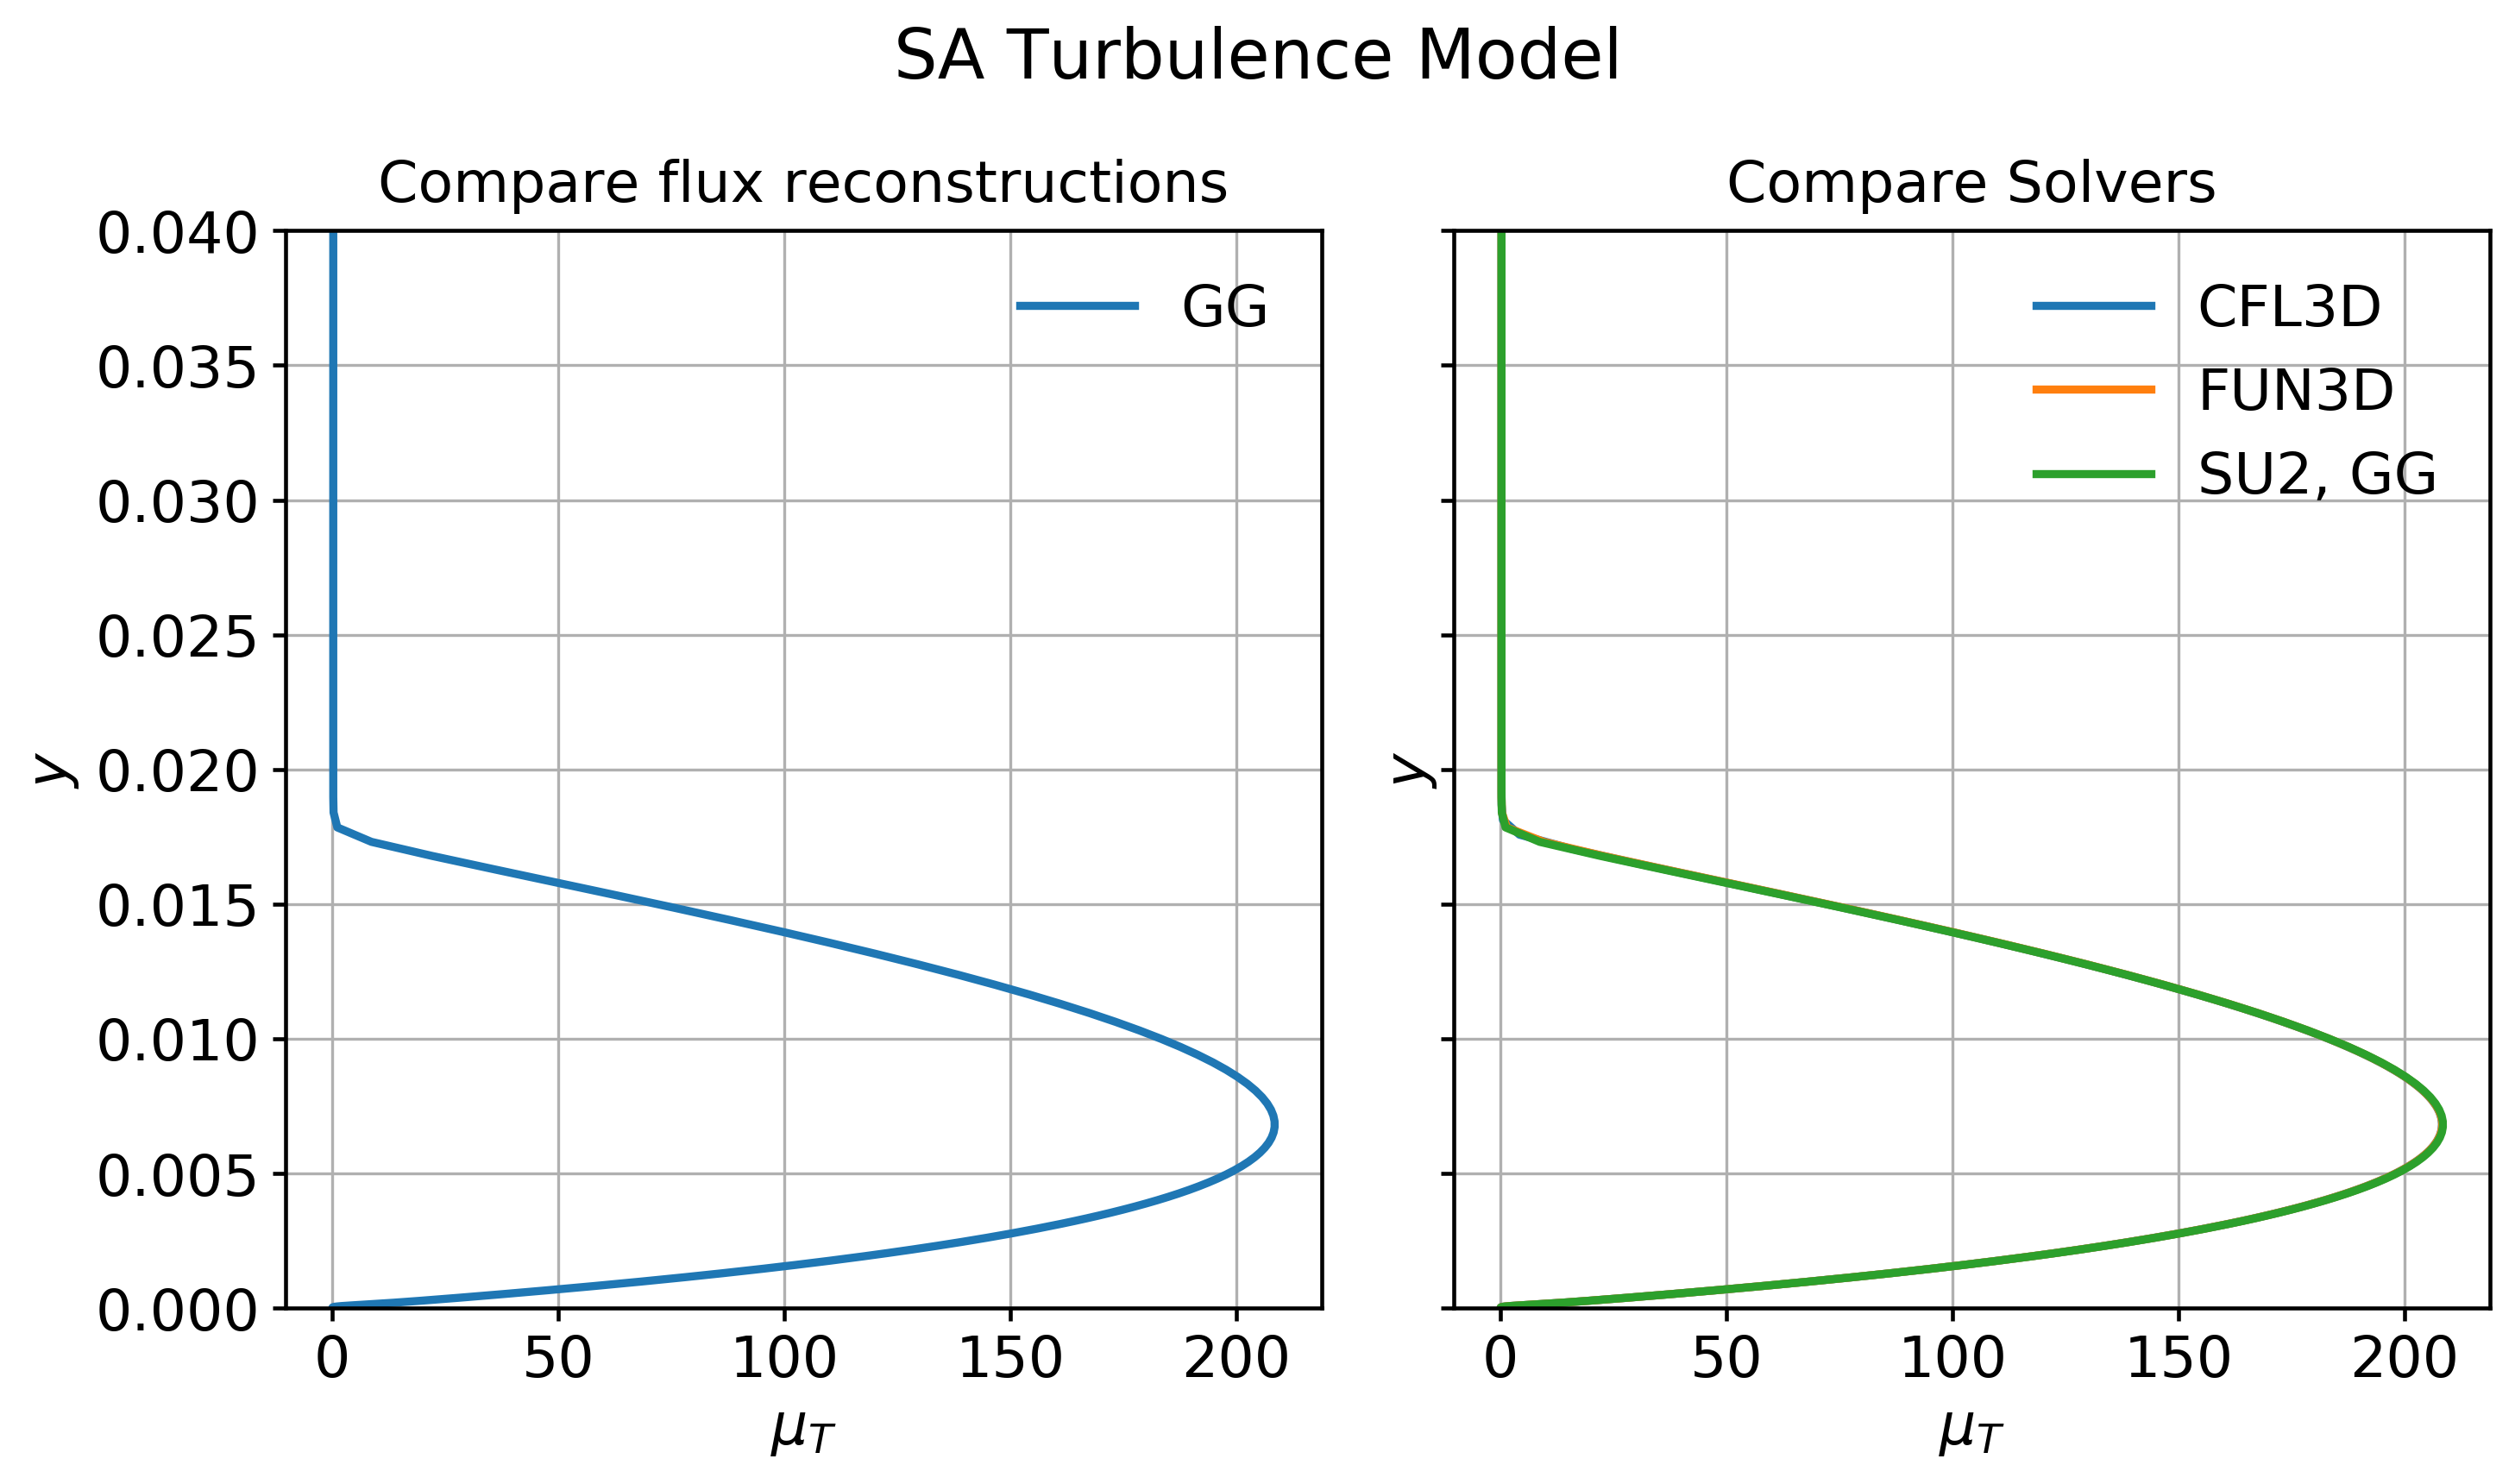

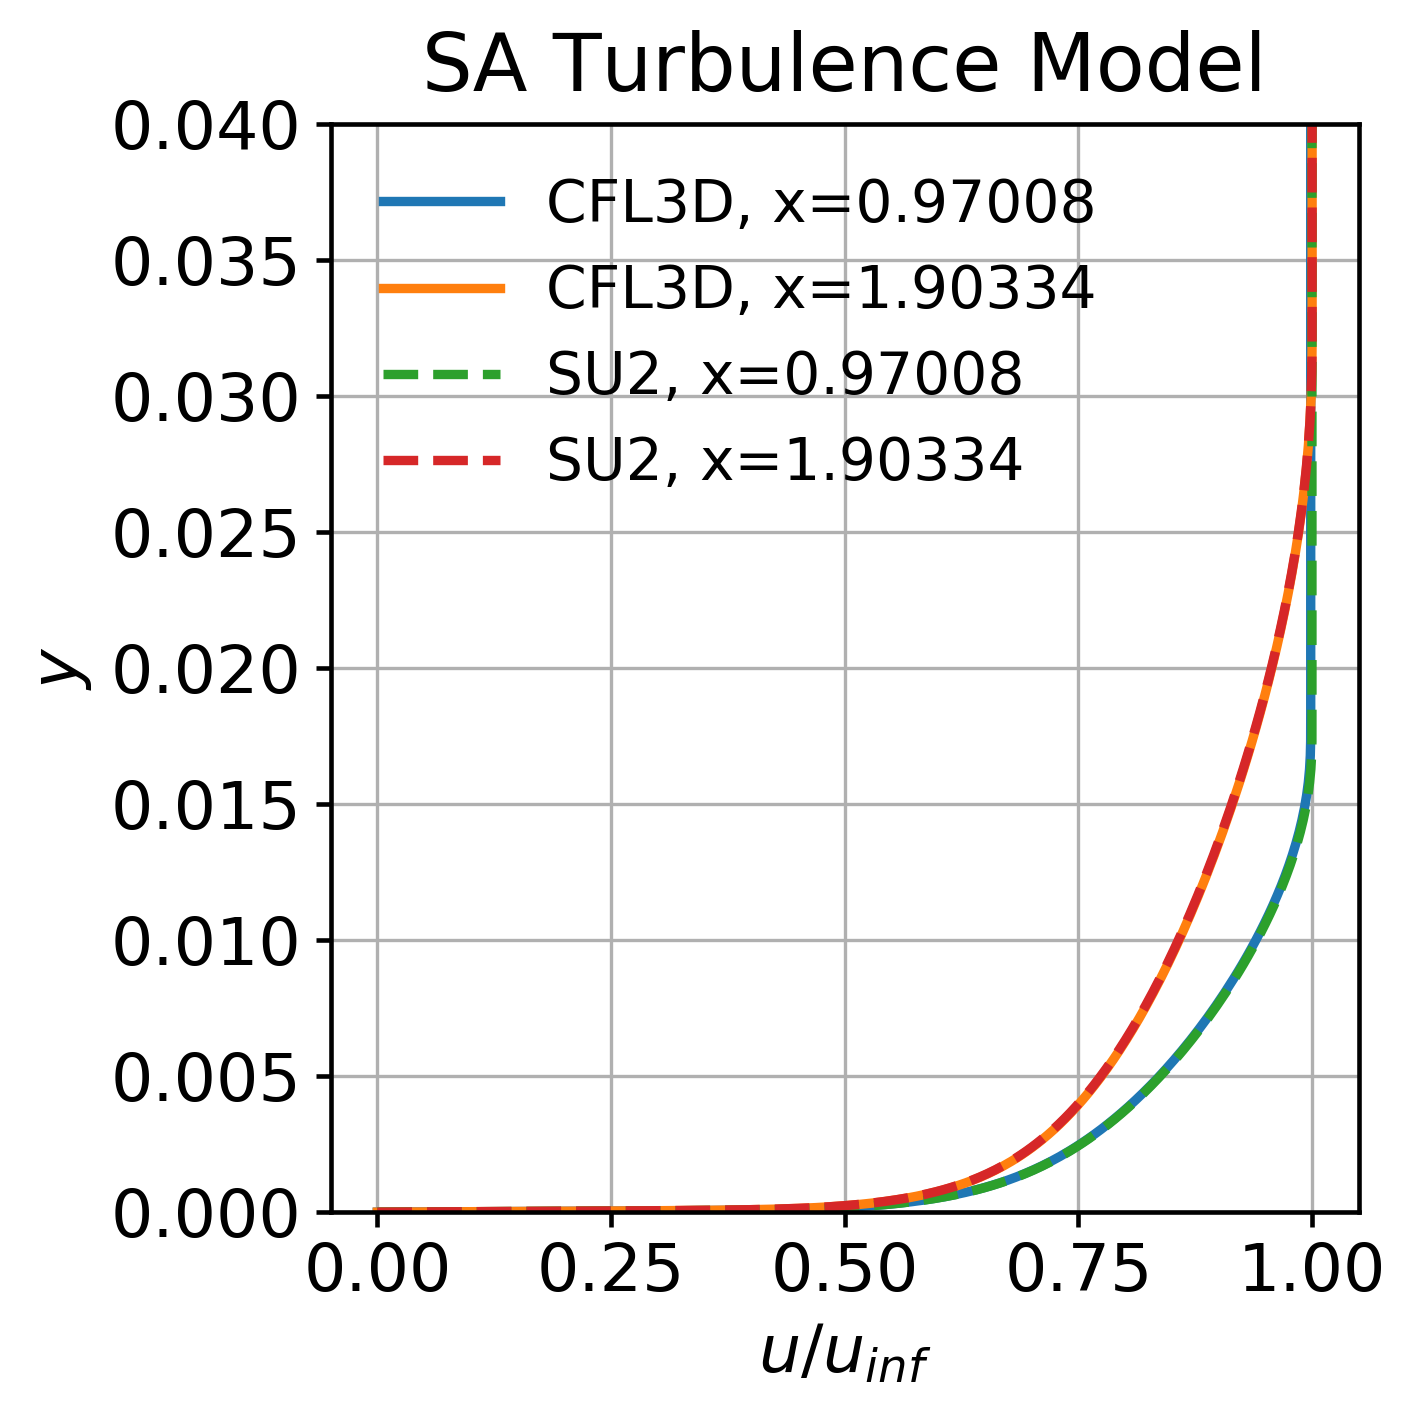

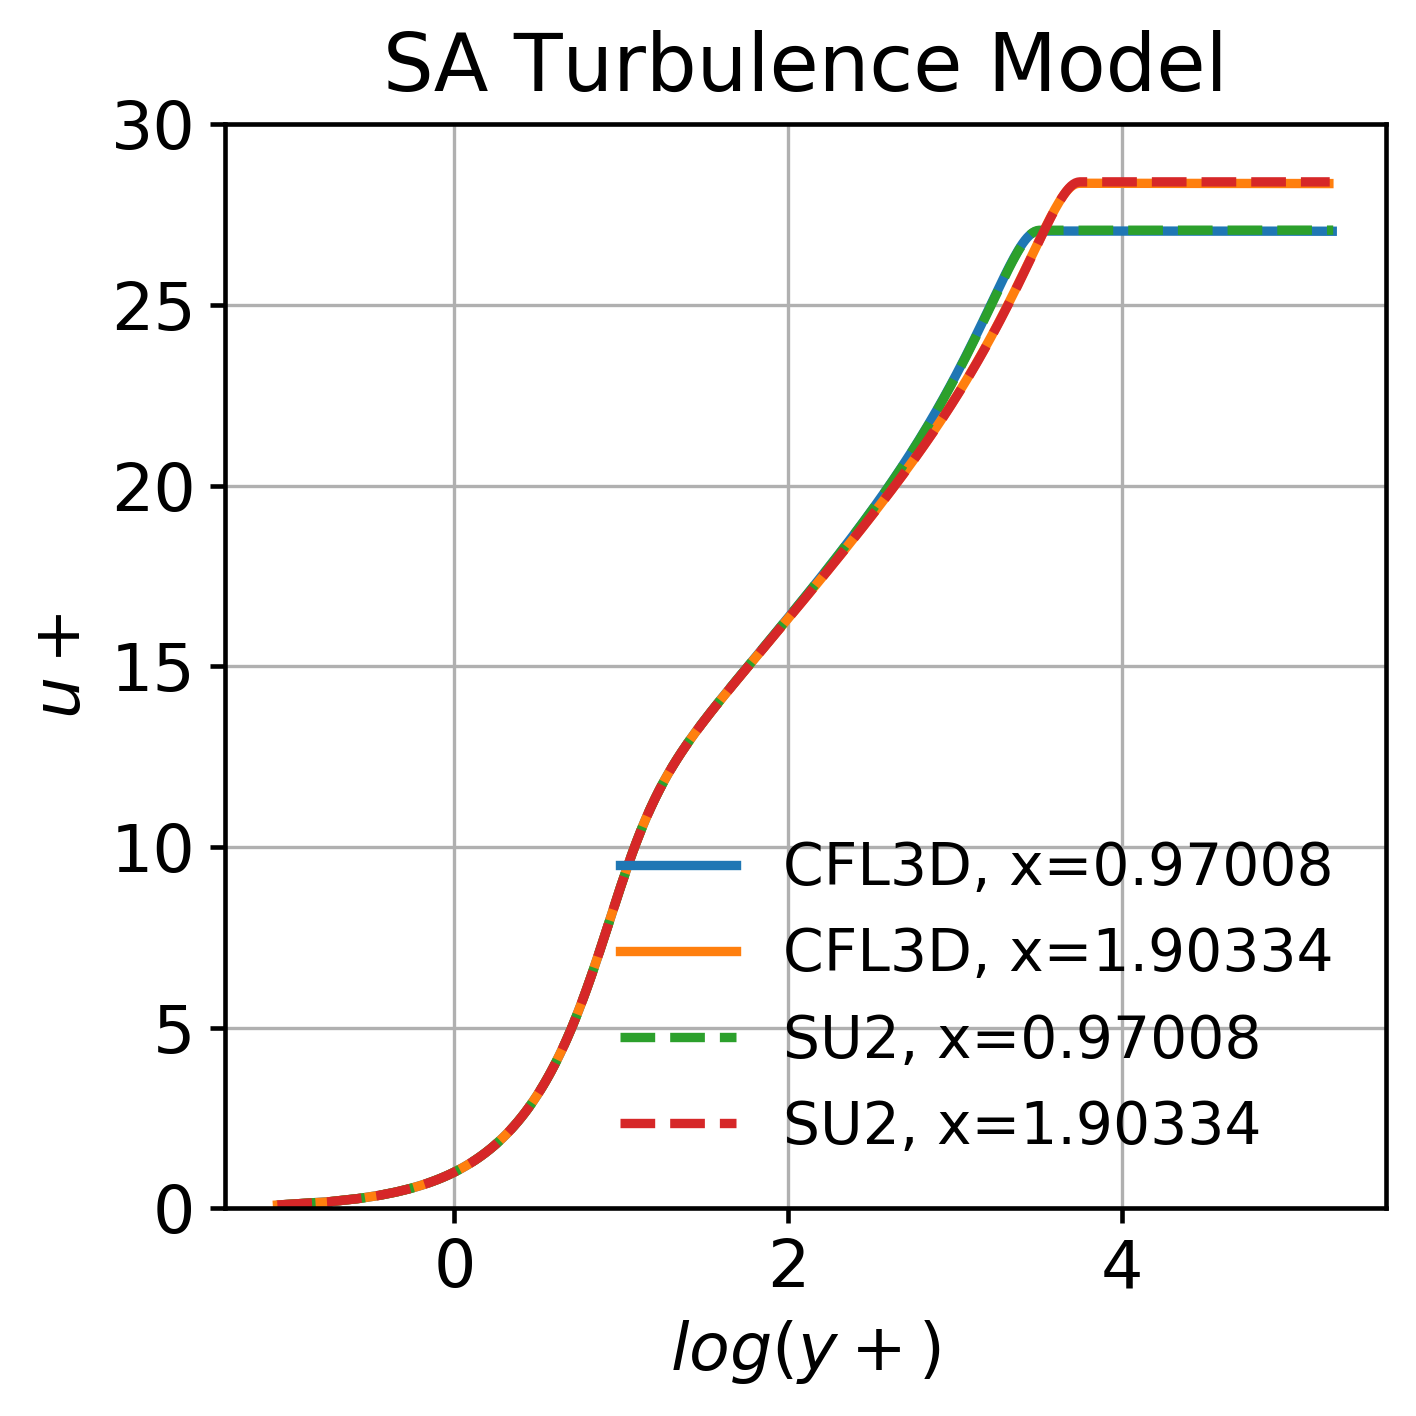

In [18]:
# Plot values at x= 0.97m for L1 mesh
coeffs = ['mut_0.97','u','u+y+','omega_k']

locs = ["x=0.97008", "x=1.90334"]
ylims = {'mut_0.97': (0.0,0.04),
         'u': (0.0,0.04),
         'u+y+' : (0,30),
         'omega_k': (10**-7,0.1)}

xlabels = {'mut_0.97': r'$\mu_T$',
           'u': r'$u/u_{inf}$',
           'u+y+' : r'$log(y+)$'}

ylabels = {'mut_0.97': r'$y$',
           'u': r'$y$',
           'u+y+' : r'$u+$'}

tmr_x_data = {'mut_0.97': 'mut',
              'u': 'u',
              'u+y+' : 'log(y+)'}

tmr_y_data = {'mut_0.97': 'y',
              'u': 'y',
              'u+y+' : 'u+'}

mu_inf = 4.73286e-08
u_inf = 0.236643

for model in models:
    for coeff in [coeffs[0]]:

        fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,5.5))
        axs[0].set_title('Compare flux reconstructions',fontsize=ts)
        axs[1].set_title('Compare Solvers',fontsize=ts)
        for solver,solver_data in tmr_line_data[model][coeff].items():
            axs[1].plot(solver_data[tmr_x_data[coeff]],solver_data[tmr_y_data[coeff]],label=solver)
        for grad in grads:
            for recon in recon_grads:
                plot_label = grad.upper()
                plot_x_data = []
                plot_y_data = []
                # Set data for the plots
                plot_x_data = run_data[model][grad][recon]["x=0.97008"]['Eddy_Viscosity']/mu_inf
                plot_y_data = run_data[model][grad][recon]["x=0.97008"]['Y']

                if 'ls' in recon:
                    plot_label += ', ' + 'LS recon.'
                axs[0].plot(plot_x_data,plot_y_data,label=plot_label)
                if '2nd_order' in recon:
                    axs[1].plot(plot_x_data,plot_y_data,label='SU2, ' + plot_label)

                fig.suptitle(plot_title + model+' Turbulence Model',y=1.05)
                for ax in axs:
                    ax.set_xlabel(xlabels[coeff])
                    ax.set_ylabel(ylabels[coeff])
                    ax.set_ylim(ylims[coeff])
                    ax.legend()
                    ax.grid('on')
                fig.tight_layout()
        plt.savefig('images/extracted_line_{}_{}.png'.format(model.lower(),coeff.lower()),dpi=300)
                
for model in models:
    for coeff in coeffs[1:3]:

        fig = plt.figure(figsize=(5,5))
        plt.title(plot_title + model+' Turbulence Model')
        for loc,loc_data in tmr_line_data[model][coeff].items():
            curr_label = 'CFL3D, ' + loc
            plt.plot(loc_data[tmr_x_data[coeff]],loc_data[tmr_y_data[coeff]],label=curr_label)
        for grad in ['gg']:
            for recon in ['2nd_order']:
                for loc in locs:
                    
                    plot_label = loc
                    plot_x_data = []
                    plot_y_data = []

                    if coeff == 'u':
                        rho = run_data[model][grad][recon][loc]["Density"].flatten()
                        u = np.divide(run_data[model][grad][recon][loc]["Momentum_X"],rho)
                        plot_x_data = u/u_inf
                        plot_y_data = run_data[model][grad][recon][loc]['Y']
                    elif coeff == 'u+y+':
                        rho = run_data[model][grad][recon][loc]["Density"].flatten()
                        u = np.divide(run_data[model][grad][recon][loc]["Momentum_X"],rho)
                        mu = run_data[model][grad][recon][loc]["Laminar_Viscosity"].flatten()
                        y = run_data[model][grad][recon][loc]["Y"]
                        uplus,yplus = calculate_uplus_yplus(y,rho,u,mu)
                        plot_x_data = np.log10(yplus[1:])
                        plot_y_data = uplus[1:]

                    plt.plot(plot_x_data,plot_y_data,label='SU2, ' + plot_label,linestyle='--')

                    plt.xlabel(xlabels[coeff])
                    plt.ylabel(ylabels[coeff])
                    plt.ylim(ylims[coeff])
                    plt.legend(fontsize=14)
                    plt.grid('on')
                    fig.tight_layout()
        plt.savefig('images/extracted_line_{}_{}.png'.format(model.lower(),coeff.lower()),dpi=300)


KeyError: 'SST'

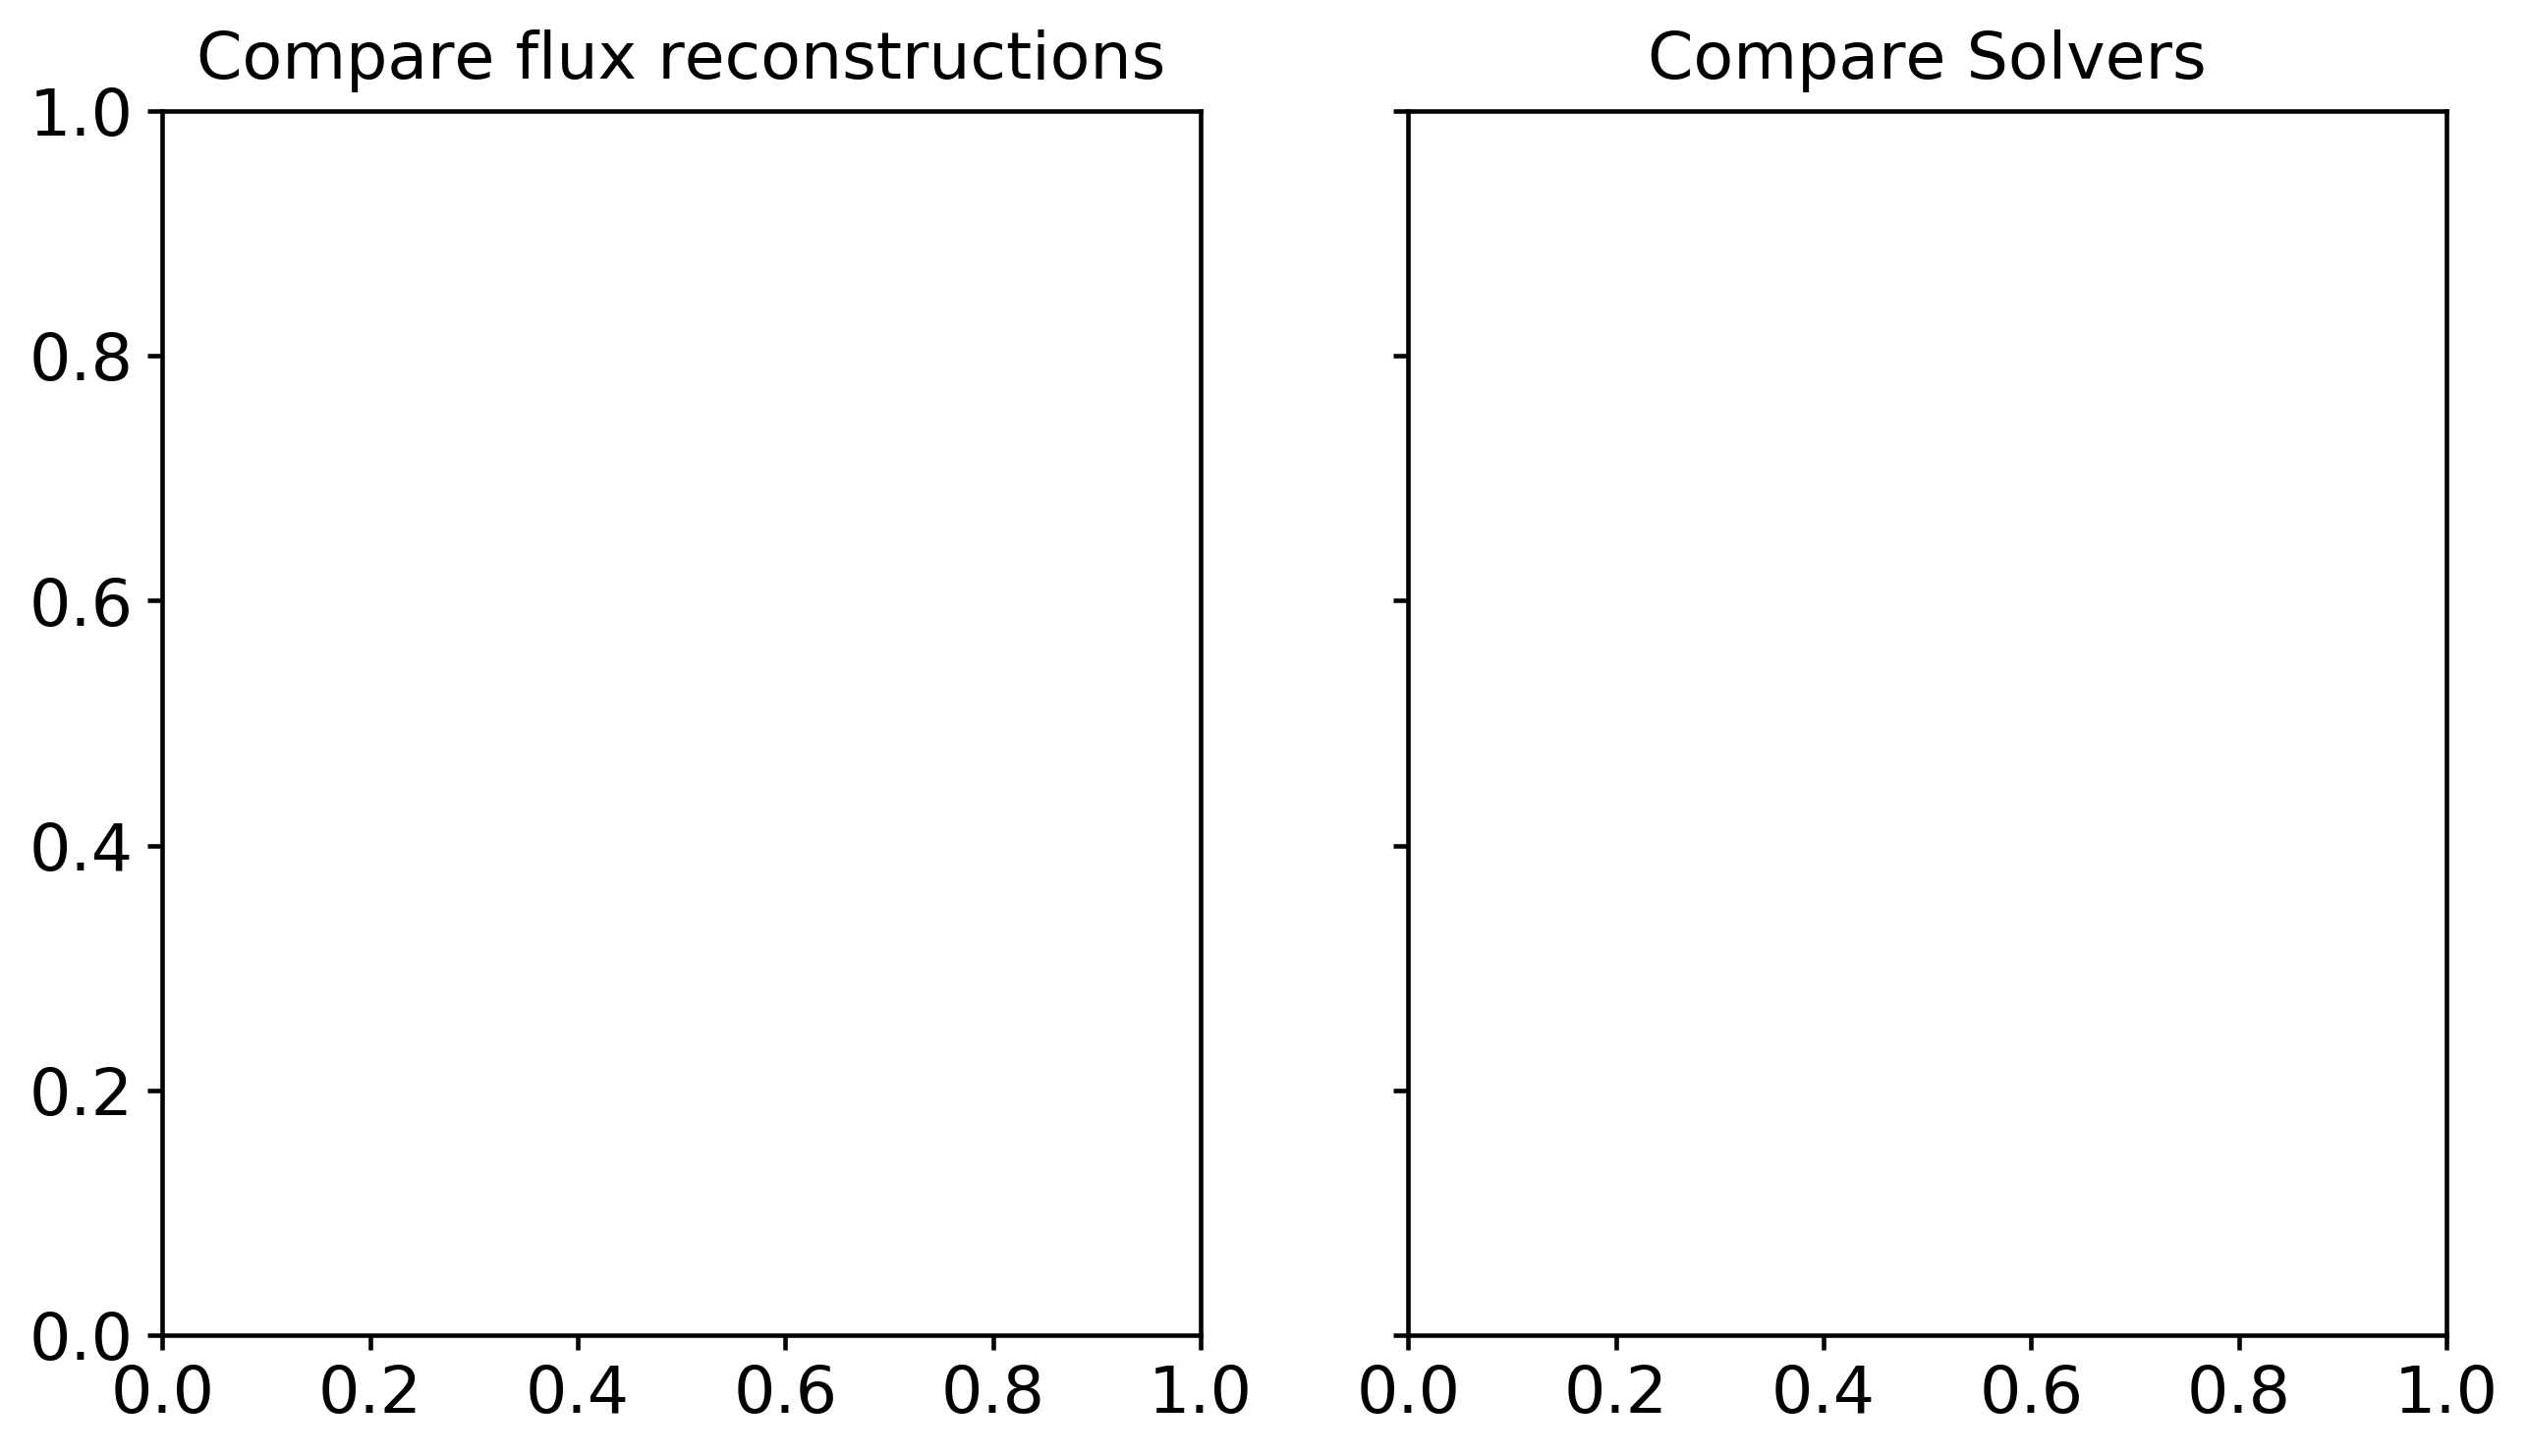

In [19]:
a_ref = u_inf/0.2
mu_ref = mu_inf
rho_ref = 1
xlabels = {'k': r'$k/a^2_{ref}$', 'omega' : r'$\omega~\mu_{ref}/(\rho_{ref}~a^2_{ref})$'}

for coeff in ['k','omega']:
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,5.5))
    axs[0].set_title('Compare flux reconstructions',fontsize=ts)
    axs[1].set_title('Compare Solvers',fontsize=ts)
    for solver,solver_data in tmr_line_data[model]['omega_k'].items():
        axs[1].plot(solver_data[coeff],solver_data['y'],label=solver)
    for grad in grads:
        for recon in recon_grads:
            plot_label = grad.upper()
            if coeff == 'omega':
                plot_x_data = run_data['SST'][grad][recon]['x=0.97008']["Omega"][1:]*mu_ref/(rho_ref*a_ref**2)
            else:
                plot_x_data = run_data['SST'][grad][recon]['x=0.97008']["Turb_Kin_Energy"][1:]/(a_ref**2)
            
            plot_y_data = run_data[model][grad][recon]["x=0.97008"]['Y'][1:]
            # Set data for the plots


            if 'ls' in recon:
                plot_label += ', ' + 'LS recon.'
            axs[0].loglog(plot_x_data,plot_y_data,label=plot_label)
            if '2nd_order' in recon:
                axs[1].loglog(plot_x_data,plot_y_data,label='SU2, ' + plot_label)

            fig.suptitle(plot_title + model+' Turbulence Model',y=1.05)
            for ax in axs:
                ax.set_xlabel(xlabels[coeff])
                ax.set_ylabel('y')
                ax.set_ylim(ylims['omega_k'])
                ax.legend()
                ax.grid('on')
            fig.tight_layout()
    plt.savefig('images/extracted_line_{}_{}.png'.format(model.lower(),coeff.lower()),dpi=300)

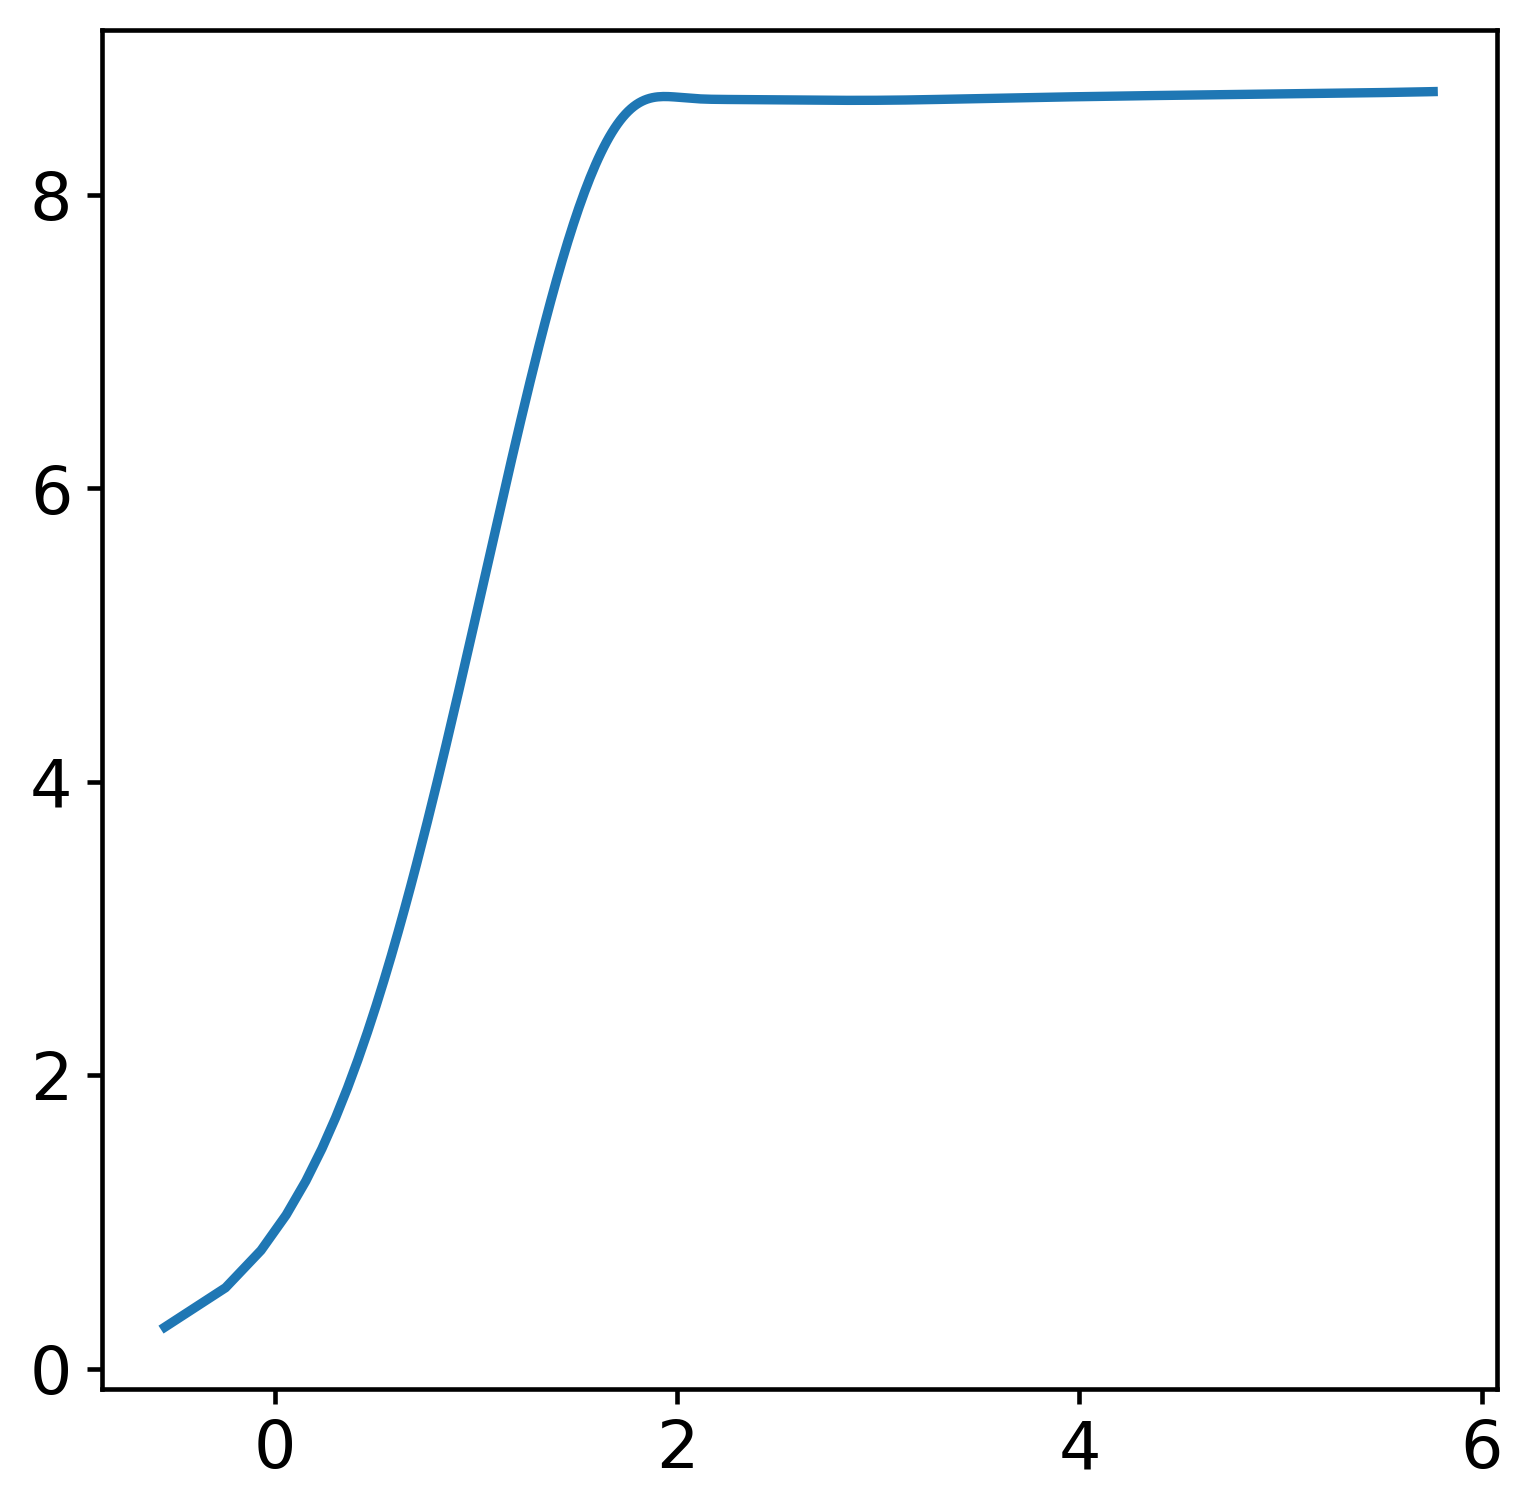

In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from vandv_tools.util import *
from vandv_tools.pv import *

vol_fn = '{}/{}/{}/{}/vol_solution.vtu'.format('SA','gg','2nd_order','L1')
pv = PVWrapper(filename = vol_fn)
extracted_line = pv.extract_variables_along_axis(loc=(0.0,0.0))

rho = extracted_line["Density"].flatten()
u = np.divide(extracted_line["Momentum"][:,0],rho)
mu = extracted_line["Laminar_Viscosity"].flatten()
y = extracted_line["Y"]
uplus,yplus = calculate_uplus_yplus(y,rho,u,mu)
plot_x_data = np.log10(yplus[1:])
plot_y_data = uplus[1:]
plt.plot(plot_x_data,plot_y_data)